Shresth Grover
190820



In [14]:
import torch 
import torch.nn as nn
import torch.distributions as dist
import matplotlib.pyplot as plt 
import numpy as np
import random

In [15]:
def target_distribution_sampling(n:int):
  mean_1 = np.array([0,1],dtype = np.float32)
  mean_2 = np.array([0,-1],dtype = np.float32)
  mean_3 = np.array([1,0],dtype = np.float32)
  mean_4 = np.array([-1,0],dtype = np.float32)
  mean = {1:mean_1,2:mean_2,3:mean_3,4:mean_4}
  scale = 4
  for i in range(n):
    choice = random.randint(1,4)
    selected_mean = scale*mean[choice]
    yield (dist.MultivariateNormal(torch.tensor(selected_mean),torch.eye(2))).sample().unsqueeze(0)



In [16]:
t=torch.zeros(1,2)
for i in target_distribution_sampling(10000):
  t=torch.concat((t,i),axis=0)


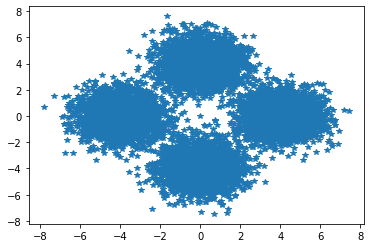

In [17]:
plt.plot(t[:,0],t[:,1],"*")

Radial Flows

In [18]:
from torch.nn.parameter import Parameter
class Radial_Flow(nn.Module):
  def __init__(self,input_shape):
    super().__init__()
    self.d = input_shape
    self.alpha = nn.Parameter(torch.empty(1))
    self.beta = nn.Parameter(torch.empty(1))
    self.z0   = nn.Parameter(torch.randn(self.d))
    nn.init.uniform_(self.beta, -1/self.d - 1.0, 1/self.d - 1.0)
    nn.init.uniform_(self.alpha, -1/self.d - 1.0, 1/self.d - 1.0)
  
  def forward(self,z:torch.Tensor):
    z_0 = z-self.z0
    r = torch.norm(z_0,dim=list(range(1,z_0.dim())))
    beta = torch.log(1 + torch.exp(self.beta)) - torch.abs(self.alpha)
    h_arr = beta / (torch.abs(self.alpha) + r)
    h_arr_ = - beta * r / (torch.abs(self.alpha) + r) ** 2
    z_ = z + h_arr.unsqueeze(1) * z_0
    log_det = (self.d - 1) * torch.log(1 + h_arr) + torch.log(1 + h_arr + h_arr_)
    return z_, log_det

    


In [19]:
class Flows(nn.Module):
  def __init__(self,input_shape,no_of_transformations=10):
    super().__init__()
    self.layers = nn.ModuleList([Radial_Flow(input_shape) for _ in range(no_of_transformations)])
    
  def forward(self,z):
    log_det_J=0
    for layer in self.layers:
      z,log_det = layer(z)
      log_det_J += log_det
    return z, log_det_J

In [20]:
def U_1(z):
  u = 0.5 * ((torch.norm(z, 2, dim=1) - 2) / 0.4) ** 2
  u = u - torch.log(
    torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2)
    + torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2)
                )
  return u

In [21]:
def sample_batch(n):
  t=torch.zeros(1,2)
  for i in target_distribution_sampling(n-1):
    t=torch.concat((t,i),axis=0)
  return t
  

In [22]:
dim = 2
no_of_layers =32
num_batches =20000
batch_size = 128 
lr =3e-4
model = Flows(input_shape=dim,no_of_transformations=32)
opt = torch.optim.Adam(model.parameters(),lr =lr)

base_dist = dist.MultivariateNormal(torch.zeros(2),torch.eye(2))
for i in range(num_batches):
  batch = torch.zeros(size=(batch_size, 2)).normal_(mean=0, std=1)
  z,log_det_J = model(batch)
  loss =  torch.mean((base_dist.log_prob(z)+U_1(z)-log_det_J))
  opt.zero_grad()
  loss.backward()
  opt.step()
  if i % 1000 == 0:
     print(f"(batch_num {i:05d}/{num_batches}) loss: {loss}")



(batch_num 00000/20000) loss: -12.163429260253906
(batch_num 01000/20000) loss: -31.405719757080078
(batch_num 02000/20000) loss: -63.540489196777344
(batch_num 03000/20000) loss: -90.14105987548828
(batch_num 04000/20000) loss: -115.75140380859375
(batch_num 05000/20000) loss: -133.8494873046875
(batch_num 06000/20000) loss: -159.21981811523438
(batch_num 07000/20000) loss: -175.80560302734375
(batch_num 08000/20000) loss: -191.2119903564453
(batch_num 09000/20000) loss: -205.3712921142578
(batch_num 10000/20000) loss: -219.8096160888672
(batch_num 11000/20000) loss: -233.76535034179688
(batch_num 12000/20000) loss: -247.7415771484375
(batch_num 13000/20000) loss: -261.94354248046875
(batch_num 14000/20000) loss: -273.91900634765625
(batch_num 15000/20000) loss: -287.46099853515625
(batch_num 16000/20000) loss: -299.616943359375
(batch_num 17000/20000) loss: -311.044921875
(batch_num 18000/20000) loss: -323.3574523925781
(batch_num 19000/20000) loss: -335.3074035644531


In [23]:
batch = torch.zeros(size=(10000, 2)).normal_(mean=0, std=1)
ans,_= model(batch)

In [24]:
ans =ans.detach()


In [ ]:
plt.plot(ans[:,0],ans[:,1])